In [25]:
# Cell 1: Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
import os
import random
from tqdm import tqdm
from utils import plot_tsne

# Set constants
NUM_CLASSES = 10
LATENT_DIM = 128
BATCH_SIZE = 64
EPOCHS_AE = 30
EPOCHS_CLS = 20
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
SEED = 42

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
# Set device
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f'Using device: {device}')


def freeze_seeds(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
freeze_seeds(SEED)

Using device: cpu
Using device: mps


In [26]:
# Cell 2: Define the Encoder - KEEPING THE EXACT SAME ARCHITECTURE
class Encoder(nn.Module):
    def __init__(self, in_channels, latent_dim):
        """
        Encoder network for the autoencoder.
        
        Args:
            in_channels: Number of input channels (1 for MNIST, 3 for CIFAR10)
            latent_dim: Dimension of the latent space (128 as per requirements)
        """
        super(Encoder, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Calculate the size of the flattened features
        if in_channels == 1:  # MNIST
            self.fc_input_size = 128 * 4 * 4
        else:  # CIFAR10
            self.fc_input_size = 128 * 4 * 4
        
        # Fully connected layer to latent space
        self.fc = nn.Linear(self.fc_input_size, latent_dim)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

In [27]:
# Cell 3: Define the Decoder - FIXED FOR MNIST DIMENSIONS
class Decoder(nn.Module):
    def __init__(self, latent_dim, out_channels):
        """
        Decoder network for the autoencoder.
        """
        super(Decoder, self).__init__()
        
        # Same initial settings
        self.initial_size = 4
        self.fc_input_size = 128 * self.initial_size * self.initial_size
        self.fc = nn.Linear(latent_dim, self.fc_input_size)
        
        # First two layers remain the same for both datasets
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        # Precise dimensions for MNIST vs CIFAR10
        if out_channels == 1:  # MNIST needs 28×28 output
            # This will output exactly 28×28
            self.deconv3 = nn.ConvTranspose2d(32, out_channels, kernel_size=1, stride=1)
            self.final_crop = True
        else:  # CIFAR10 needs 32×32 output
            self.deconv3 = nn.ConvTranspose2d(32, out_channels, kernel_size=4, stride=2, padding=1)
            self.final_crop = False
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 128, self.initial_size, self.initial_size)  # 4×4
        x = F.relu(self.bn1(self.deconv1(x)))  # 8×8
        x = F.relu(self.bn2(self.deconv2(x)))  # 16×16
        
        if self.final_crop:  # MNIST case
            # First upsample to 32×32
            x = F.interpolate(x, size=(28, 28), mode='bilinear', align_corners=False)
            # Then apply the final convolution to keep channel dimensions
            x = torch.tanh(self.deconv3(x))  # Still 28×28
        else:  # CIFAR10 case
            x = torch.tanh(self.deconv3(x))  # 32×32
            
        return x

In [28]:
# Cell 4: Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        """
        Complete autoencoder model.
        
        Args:
            encoder: Encoder network
            decoder: Decoder network
        """
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

In [29]:
# Cell 5: Define the Classifier
class Classifier(nn.Module):
    def __init__(self, latent_dim, num_classes):
        """
        Classifier that uses the latent representation from the encoder.
        
        Args:
            latent_dim: Dimension of the latent space
            num_classes: Number of output classes (10 for both MNIST and CIFAR10)
        """
        super(Classifier, self).__init__()
        
        # Simple MLP classifier
        self.fc1 = nn.Linear(latent_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [30]:
# Cell 6: Training and Evaluation Functions
def train_autoencoder(model, train_loader, val_loader, num_epochs, device, lr=1e-3, weight_decay=1e-5):
    """
    Train the autoencoder model.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    mse_criterion = nn.MSELoss()
    
    model.train()
    mse_losses = []
    mae_losses = []
    val_mse_losses = []
    val_mae_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        epoch_mse_loss = 0.0
        epoch_mae_loss = 0.0
        num_batches = 0
        
        for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            data = data.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            reconstructed, _ = model(data)
            mse_loss = mse_criterion(reconstructed, data)
            
            # Calculate MAE for reporting (not used for optimization)
            mae_loss = torch.mean(torch.abs(reconstructed - data))
            
            # Backward pass and optimize
            mse_loss.backward()
            optimizer.step()
            
            epoch_mse_loss += mse_loss.item()
            epoch_mae_loss += mae_loss.item()
            num_batches += 1
        
        avg_epoch_mse_loss = epoch_mse_loss / num_batches
        avg_epoch_mae_loss = epoch_mae_loss / num_batches
        mse_losses.append(avg_epoch_mse_loss)
        mae_losses.append(avg_epoch_mae_loss)
        
        # Validation
        model.eval()
        val_epoch_mse_loss = 0.0
        val_epoch_mae_loss = 0.0
        val_num_batches = 0
        
        with torch.no_grad():
            for val_data, _ in val_loader:
                val_data = val_data.to(device)
                val_reconstructed, _ = model(val_data)
                
                val_mse_loss = mse_criterion(val_reconstructed, val_data)
                val_mae_loss = torch.mean(torch.abs(val_reconstructed - val_data))
                
                val_epoch_mse_loss += val_mse_loss.item()
                val_epoch_mae_loss += val_mae_loss.item()
                val_num_batches += 1
        
        avg_val_epoch_mse_loss = val_epoch_mse_loss / val_num_batches
        avg_val_epoch_mae_loss = val_epoch_mae_loss / val_num_batches
        val_mse_losses.append(avg_val_epoch_mse_loss)
        val_mae_losses.append(avg_val_epoch_mae_loss)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train MSE: {avg_epoch_mse_loss:.6f}, Train MAE: {avg_epoch_mae_loss:.6f}, Val MSE: {avg_val_epoch_mse_loss:.6f}, Val MAE: {avg_val_epoch_mae_loss:.6f}")
    
    return model, mse_losses, mae_losses, val_mse_losses, val_mae_losses

def train_classifier(encoder, classifier, train_loader, val_loader, num_epochs, device, lr=1e-3, weight_decay=1e-5):
    """
    Train the classifier using the encoder's latent representations.
    """
    optimizer = optim.Adam(classifier.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    
    encoder.eval()  # Freeze the encoder
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training
        classifier.train()
        epoch_loss = 0.0
        correct = 0
        total = 0
        num_batches = 0
        
        for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            data, targets = data.to(device), targets.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            with torch.no_grad():
                latent = encoder(data)  # Get latent representation (no gradients)
            
            outputs = classifier(latent)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        avg_epoch_loss = epoch_loss / num_batches
        epoch_accuracy = 100.0 * correct / total
        
        train_losses.append(avg_epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        # Validation
        classifier.eval()
        val_epoch_loss = 0.0
        val_correct = 0
        val_total = 0
        val_num_batches = 0
        
        with torch.no_grad():
            for val_data, val_targets in val_loader:
                val_data, val_targets = val_data.to(device), val_targets.to(device)
                
                val_latent = encoder(val_data)
                val_outputs = classifier(val_latent)
                val_loss = criterion(val_outputs, val_targets)
                
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_targets.size(0)
                val_correct += (val_predicted == val_targets).sum().item()
                
                val_epoch_loss += val_loss.item()
                val_num_batches += 1
        
        avg_val_epoch_loss = val_epoch_loss / val_num_batches
        val_epoch_accuracy = 100.0 * val_correct / val_total
        
        val_losses.append(avg_val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_epoch_loss:.6f}, Train Acc: {epoch_accuracy:.2f}%, Val Loss: {avg_val_epoch_loss:.6f}, Val Acc: {val_epoch_accuracy:.2f}%")
    
    return classifier, train_losses, train_accuracies, val_losses, val_accuracies

def evaluate_classifier(encoder, classifier, dataloader, device):
    """
    Evaluate the classifier on a test dataset.
    """
    encoder.eval()
    classifier.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, targets in tqdm(dataloader, desc="Evaluating"):
            data, targets = data.to(device), targets.to(device)
            
            # Get latent representation
            latent = encoder(data)
            
            # Forward pass through classifier
            outputs = classifier(latent)
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    accuracy = 100.0 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    return accuracy

In [31]:
# Cell 7: Visualization Functions
def plot_training_curve(losses, val_losses, title, ylabel, save_path=None):
    """
    Plot training and validation curves.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    
    if save_path:
        plt.savefig(save_path)
        
    plt.show()

def plot_reconstructions(model, dataloader, device, num_samples=5, save_path=None):
    """
    Plot original images and their reconstructions.
    """
    model.eval()
    
    # Get a batch of images
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images = images[:num_samples].to(device)
    labels = labels[:num_samples]
    
    # Reconstruct images
    with torch.no_grad():
        reconstructions, _ = model(images)
    
    # Move to CPU and convert to numpy for plotting
    images = images.cpu().numpy()
    reconstructions = reconstructions.cpu().numpy()
    
    # Plot original and reconstructed images
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))
    
    for i in range(num_samples):
        # Plot original
        img = np.transpose(images[i], (1, 2, 0))  # CHW -> HWC
        img = (img + 1) / 2.0  # Scale from [-1, 1] to [0, 1]
        if img.shape[2] == 1:  # Grayscale
            img = img.squeeze(2)
            axes[0, i].imshow(img, cmap='gray')
        else:  # RGB
            axes[0, i].imshow(img)
        axes[0, i].set_title(f"Label: {labels[i].item()}")
        axes[0, i].axis('off')
        
        # Plot reconstruction
        recon = np.transpose(reconstructions[i], (1, 2, 0))  # CHW -> HWC
        recon = (recon + 1) / 2.0  # Scale from [-1, 1] to [0, 1]
        if recon.shape[2] == 1:  # Grayscale
            recon = recon.squeeze(2)
            axes[1, i].imshow(recon, cmap='gray')
        else:  # RGB
            axes[1, i].imshow(recon)
        axes[1, i].axis('off')
    
    axes[0, 0].set_ylabel('Original')
    axes[1, 0].set_ylabel('Reconstructed')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()
    
    return images, labels

def latent_interpolation(encoder, decoder, img1, img2, steps=10, device=device, save_path=None):
    """
    Perform linear interpolation in the latent space between two images.
    
    Args:
        encoder: Trained encoder model
        decoder: Trained decoder model
        img1: First image tensor
        img2: Second image tensor
        steps: Number of interpolation steps
        device: Device to use
        save_path: Path to save the interpolation plot
    """
    # Ensure images are tensors on the correct device
    img1 = img1.unsqueeze(0).to(device) if not isinstance(img1, torch.Tensor) else img1.to(device)
    img2 = img2.unsqueeze(0).to(device) if not isinstance(img2, torch.Tensor) else img2.to(device)
    
    if len(img1.shape) == 3:
        img1 = img1.unsqueeze(0)
    if len(img2.shape) == 3:
        img2 = img2.unsqueeze(0)
    
    # Encode images
    with torch.no_grad():
        latent1 = encoder(img1)
        latent2 = encoder(img2)
    
    # Interpolate between latent vectors
    alphas = torch.linspace(0, 1, steps)
    interpolated_images = []
    
    with torch.no_grad():
        for alpha in alphas:
            # Linear interpolation
            interpolated_latent = (1 - alpha) * latent1 + alpha * latent2
            # Decode
            decoded_img = decoder(interpolated_latent)
            interpolated_images.append(decoded_img.cpu())
    
    # Visualize the interpolation
    fig, axes = plt.subplots(1, steps, figsize=(20, 4))

In [32]:
# Cell 8: Setup Dataset
# Choose dataset - run this cell for MNIST
use_mnist = True
DATA_PATH = './datasets/cv_datasets/data'


# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5] if use_mnist else [0.5, 0.5, 0.5], 
                        std=[0.5] if use_mnist else [0.5, 0.5, 0.5])  # Scale to [-1, 1]
])

# Load dataset
if use_mnist:
    print("Using MNIST dataset")
    train_dataset = datasets.MNIST(root=DATA_PATH, train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root=DATA_PATH, train=False, download=True, transform=transform)
    in_channels = 1
else:
    print("Using CIFAR10 dataset")
    train_dataset = datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transform)
    in_channels = 3

# Split train into train and validation
val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Using MNIST dataset
Train set size: 54000
Validation set size: 6000
Test set size: 10000


In [33]:
# Cell 9: Initialize Models
# Initialize encoder and decoder
encoder = Encoder(in_channels, LATENT_DIM).to(device)
decoder = Decoder(LATENT_DIM, in_channels).to(device)
autoencoder = Autoencoder(encoder, decoder).to(device)
classifier = Classifier(LATENT_DIM, NUM_CLASSES).to(device)

# Print model architectures
print("Encoder Architecture:")
print(encoder)
print("\nDecoder Architecture:")
print(decoder)
print("\nClassifier Architecture:")
print(classifier)

# Check a sample forward pass
sample = next(iter(train_loader))[0][:1].to(device)
print(f"\nSample shape: {sample.shape}")
reconstructed, latent = autoencoder(sample)
print(f"Latent shape: {latent.shape}")
print(f"Reconstructed shape: {reconstructed.shape}")

Encoder Architecture:
Encoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=2048, out_features=128, bias=True)
)

Decoder Architecture:
Decoder(
  (fc): Linear(in_features=128, out_features=2048, bias=True)
  (deconv1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0

/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 


Sample shape: torch.Size([1, 1, 28, 28])
Latent shape: torch.Size([1, 128])
Reconstructed shape: torch.Size([1, 1, 28, 28])



--- Training Autoencoder ---


Epoch 1/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: U

Epoch [1/30], Train MSE: 0.037464, Train MAE: 0.063601, Val MSE: 0.016034, Val MAE: 0.041700


Epoch 2/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: U

Epoch [2/30], Train MSE: 0.014459, Train MAE: 0.039448, Val MSE: 0.012578, Val MAE: 0.036822


Epoch 3/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: U

Epoch [3/30], Train MSE: 0.012051, Train MAE: 0.035730, Val MSE: 0.012967, Val MAE: 0.036074


Epoch 4/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: U

Epoch [4/30], Train MSE: 0.011237, Train MAE: 0.034352, Val MSE: 0.010343, Val MAE: 0.032807


Epoch 5/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: U

Epoch [5/30], Train MSE: 0.010431, Train MAE: 0.033021, Val MSE: 0.010094, Val MAE: 0.032251


Epoch 6/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: U

Epoch [6/30], Train MSE: 0.009947, Train MAE: 0.032140, Val MSE: 0.010268, Val MAE: 0.032188


Epoch 7/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: U

Epoch [7/30], Train MSE: 0.009540, Train MAE: 0.031349, Val MSE: 0.009872, Val MAE: 0.032092


Epoch 8/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: U

Epoch [8/30], Train MSE: 0.009305, Train MAE: 0.030886, Val MSE: 0.009204, Val MAE: 0.030922


Epoch 9/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: U

Epoch [9/30], Train MSE: 0.009000, Train MAE: 0.030283, Val MSE: 0.009158, Val MAE: 0.030734


Epoch 10/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [10/30], Train MSE: 0.008673, Train MAE: 0.029649, Val MSE: 0.008768, Val MAE: 0.029392


Epoch 11/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [11/30], Train MSE: 0.008513, Train MAE: 0.029301, Val MSE: 0.008364, Val MAE: 0.029076


Epoch 12/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [12/30], Train MSE: 0.008132, Train MAE: 0.028578, Val MSE: 0.008402, Val MAE: 0.028630


Epoch 13/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [13/30], Train MSE: 0.007993, Train MAE: 0.028292, Val MSE: 0.007788, Val MAE: 0.027906


Epoch 14/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [14/30], Train MSE: 0.007867, Train MAE: 0.028048, Val MSE: 0.008240, Val MAE: 0.028629


Epoch 15/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [15/30], Train MSE: 0.007718, Train MAE: 0.027749, Val MSE: 0.007631, Val MAE: 0.027594


Epoch 16/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [16/30], Train MSE: 0.007587, Train MAE: 0.027505, Val MSE: 0.007915, Val MAE: 0.027884


Epoch 17/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [17/30], Train MSE: 0.007423, Train MAE: 0.027200, Val MSE: 0.008596, Val MAE: 0.029704


Epoch 18/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [18/30], Train MSE: 0.007416, Train MAE: 0.027161, Val MSE: 0.007069, Val MAE: 0.026574


Epoch 19/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [19/30], Train MSE: 0.007322, Train MAE: 0.026977, Val MSE: 0.006995, Val MAE: 0.026401


Epoch 20/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [20/30], Train MSE: 0.007274, Train MAE: 0.026866, Val MSE: 0.006996, Val MAE: 0.026260


Epoch 21/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [21/30], Train MSE: 0.007119, Train MAE: 0.026577, Val MSE: 0.006978, Val MAE: 0.026178


Epoch 22/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [22/30], Train MSE: 0.007074, Train MAE: 0.026481, Val MSE: 0.007112, Val MAE: 0.026711


Epoch 23/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [23/30], Train MSE: 0.007045, Train MAE: 0.026418, Val MSE: 0.006802, Val MAE: 0.025809


Epoch 24/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [24/30], Train MSE: 0.007005, Train MAE: 0.026341, Val MSE: 0.006885, Val MAE: 0.026058


Epoch 25/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [25/30], Train MSE: 0.006919, Train MAE: 0.026163, Val MSE: 0.006723, Val MAE: 0.025818


Epoch 26/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [26/30], Train MSE: 0.006928, Train MAE: 0.026184, Val MSE: 0.006733, Val MAE: 0.025926


Epoch 27/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [27/30], Train MSE: 0.006858, Train MAE: 0.026056, Val MSE: 0.006908, Val MAE: 0.026253


Epoch 28/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [28/30], Train MSE: 0.006814, Train MAE: 0.025947, Val MSE: 0.006518, Val MAE: 0.025096


Epoch 29/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [29/30], Train MSE: 0.006792, Train MAE: 0.025908, Val MSE: 0.006733, Val MAE: 0.025702


Epoch 30/30:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [30/30], Train MSE: 0.006715, Train MAE: 0.025755, Val MSE: 0.006665, Val MAE: 0.025687


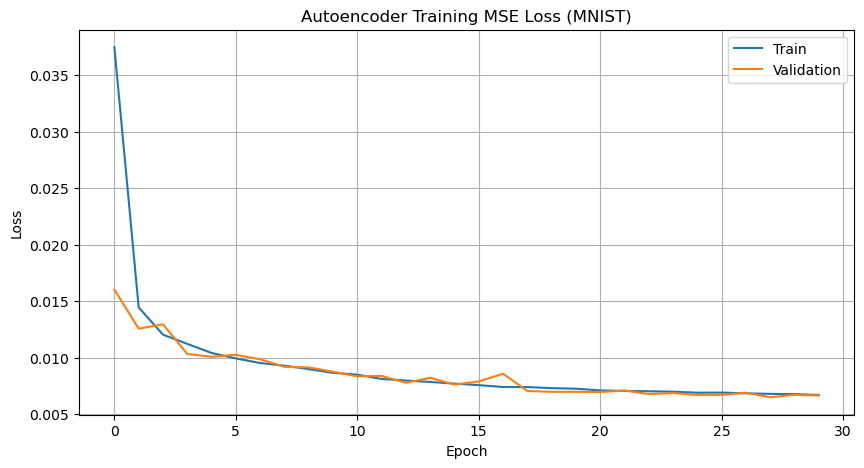

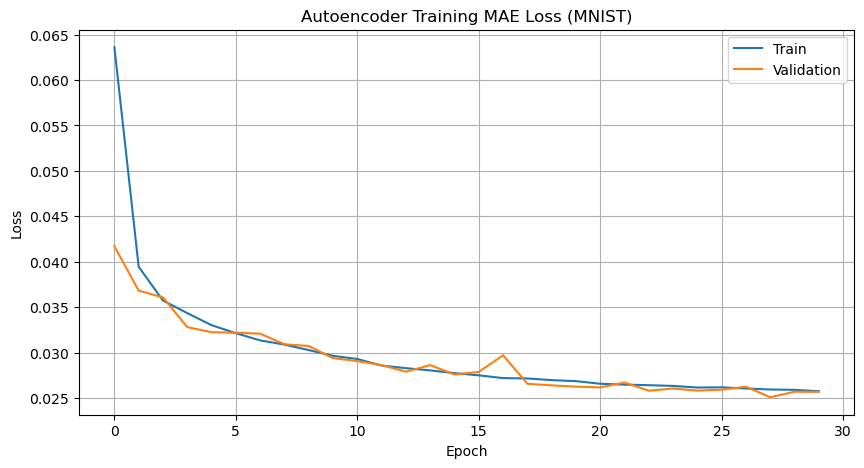

/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 

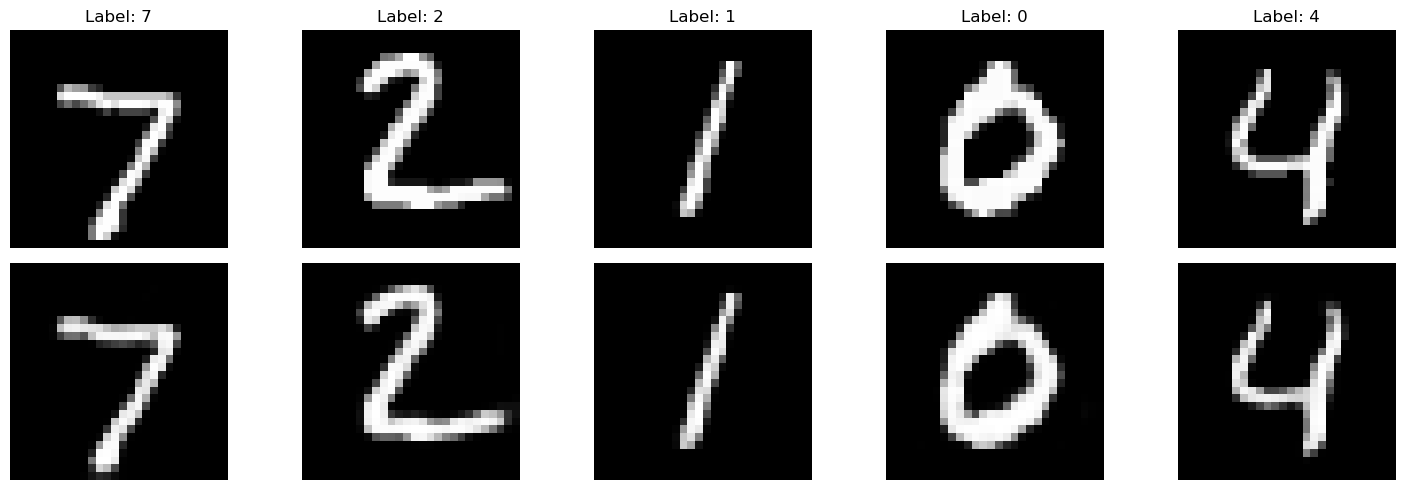

In [34]:
# Cell 10: Train Autoencoder
# Train autoencoder
print("\n--- Training Autoencoder ---")
autoencoder, mse_losses, mae_losses, val_mse_losses, val_mae_losses = train_autoencoder(
    autoencoder, train_loader, val_loader, EPOCHS_AE, device,
    lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

# Plot training curves
plot_training_curve(
    mse_losses, val_mse_losses,
    f'Autoencoder Training MSE Loss ({("MNIST" if use_mnist else "CIFAR10")})',
    'Loss',
    save_path=f'autoencoder_mse_loss_{("mnist" if use_mnist else "cifar10")}.png'
)

plot_training_curve(
    mae_losses, val_mae_losses,
    f'Autoencoder Training MAE Loss ({("MNIST" if use_mnist else "CIFAR10")})',
    'Loss',
    save_path=f'autoencoder_mae_loss_{("mnist" if use_mnist else "cifar10")}.png'
)

# Plot reconstructions
orig_images, orig_labels = plot_reconstructions(
    autoencoder, test_loader, device, num_samples=5,
    save_path=f'reconstructions_{("mnist" if use_mnist else "cifar10")}.png'
)


--- Performing Linear Interpolation in Latent Space ---


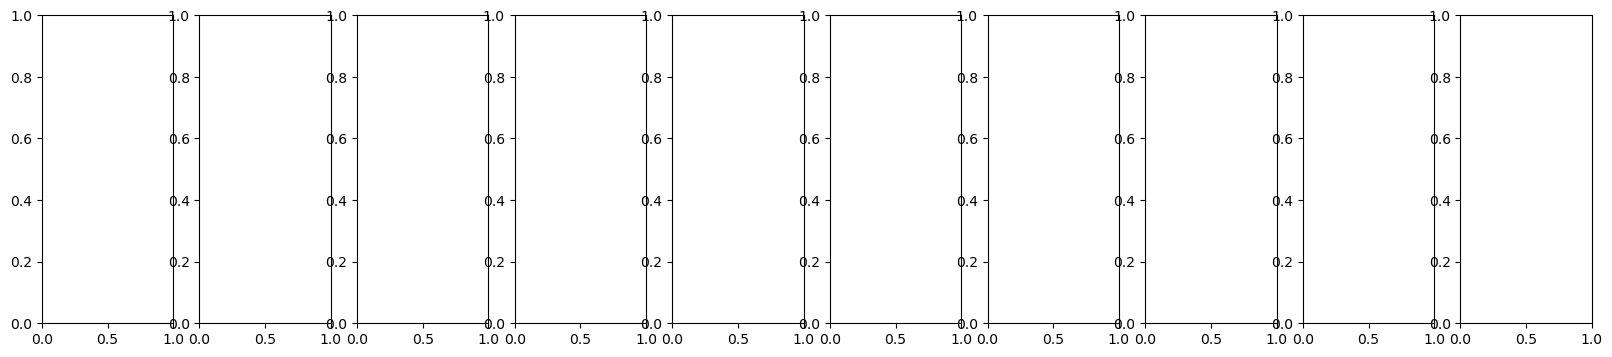

In [35]:
# Cell 11: Linear Interpolation (for MNIST)
if use_mnist:
    print("\n--- Performing Linear Interpolation in Latent Space ---")
    # Select 2 images from the previously visualized ones
    img1 = torch.from_numpy(orig_images[0])
    img2 = torch.from_numpy(orig_images[1])
    
    # Perform interpolation
    latent_interpolation(
        encoder, decoder, img1, img2, steps=10, device=device,
        save_path=f'interpolation_mnist.png'
    )


--- Training Classifier on Encoder's Representations ---


Epoch 1/20:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: U

Epoch [1/20], Train Loss: 0.264097, Train Acc: 92.89%, Val Loss: 0.118038, Val Acc: 96.47%


Epoch 2/20:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: U

Epoch [2/20], Train Loss: 0.096113, Train Acc: 97.02%, Val Loss: 0.099998, Val Acc: 96.90%


Epoch 3/20:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: U

Epoch [3/20], Train Loss: 0.063980, Train Acc: 98.03%, Val Loss: 0.082618, Val Acc: 97.50%


Epoch 4/20:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: U

Epoch [4/20], Train Loss: 0.048384, Train Acc: 98.44%, Val Loss: 0.081200, Val Acc: 97.47%


Epoch 5/20:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: U

Epoch [5/20], Train Loss: 0.039133, Train Acc: 98.72%, Val Loss: 0.093724, Val Acc: 97.13%


Epoch 6/20:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: U

Epoch [6/20], Train Loss: 0.032854, Train Acc: 98.88%, Val Loss: 0.075823, Val Acc: 97.90%


Epoch 7/20:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: U

Epoch [7/20], Train Loss: 0.027413, Train Acc: 99.13%, Val Loss: 0.088560, Val Acc: 97.27%


Epoch 8/20:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: U

Epoch [8/20], Train Loss: 0.025106, Train Acc: 99.16%, Val Loss: 0.079429, Val Acc: 97.80%


Epoch 9/20:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: U

Epoch [9/20], Train Loss: 0.024073, Train Acc: 99.19%, Val Loss: 0.084091, Val Acc: 97.47%


Epoch 10/20:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [10/20], Train Loss: 0.018158, Train Acc: 99.37%, Val Loss: 0.087819, Val Acc: 97.55%


Epoch 11/20:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [11/20], Train Loss: 0.016946, Train Acc: 99.39%, Val Loss: 0.076677, Val Acc: 98.07%


Epoch 12/20:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [12/20], Train Loss: 0.016555, Train Acc: 99.44%, Val Loss: 0.087699, Val Acc: 97.70%


Epoch 13/20:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [13/20], Train Loss: 0.017238, Train Acc: 99.44%, Val Loss: 0.081913, Val Acc: 97.80%


Epoch 14/20:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [14/20], Train Loss: 0.014554, Train Acc: 99.54%, Val Loss: 0.091585, Val Acc: 97.65%


Epoch 15/20:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [15/20], Train Loss: 0.012444, Train Acc: 99.58%, Val Loss: 0.089888, Val Acc: 97.60%


Epoch 16/20:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [16/20], Train Loss: 0.013371, Train Acc: 99.56%, Val Loss: 0.086761, Val Acc: 97.88%


Epoch 17/20:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [17/20], Train Loss: 0.012167, Train Acc: 99.61%, Val Loss: 0.087348, Val Acc: 97.67%


Epoch 18/20:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [18/20], Train Loss: 0.012482, Train Acc: 99.55%, Val Loss: 0.088277, Val Acc: 97.98%


Epoch 19/20:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [19/20], Train Loss: 0.011541, Train Acc: 99.62%, Val Loss: 0.095929, Val Acc: 97.30%


Epoch 20/20:   0%|          | 0/844 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: 

Epoch [20/20], Train Loss: 0.010373, Train Acc: 99.69%, Val Loss: 0.078452, Val Acc: 98.12%


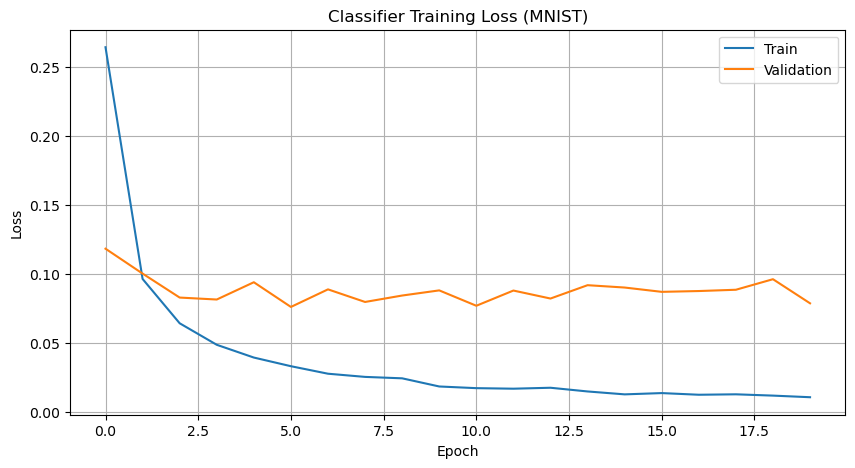

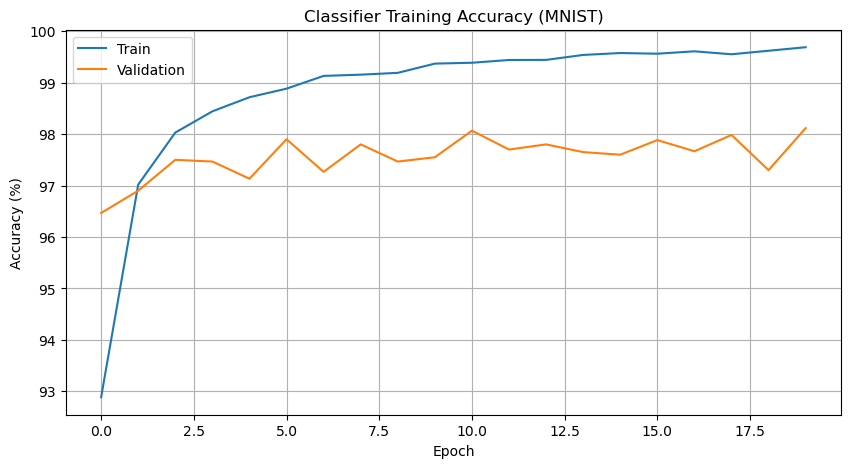

In [36]:
# Cell 12: Train Classifier
# Train classifier on frozen encoder
print("\n--- Training Classifier on Encoder's Representations ---")
classifier, train_losses, train_accuracies, val_losses, val_accuracies = train_classifier(
    encoder, classifier, train_loader, val_loader, EPOCHS_CLS, device,
    lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

# Plot training curves
plot_training_curve(
    train_losses, val_losses,
    f'Classifier Training Loss ({("MNIST" if use_mnist else "CIFAR10")})',
    'Loss',
    save_path=f'classifier_loss_{("mnist" if use_mnist else "cifar10")}.png'
)

plot_training_curve(
    train_accuracies, val_accuracies,
    f'Classifier Training Accuracy ({("MNIST" if use_mnist else "CIFAR10")})',
    'Accuracy (%)',
    save_path=f'classifier_accuracy_{("mnist" if use_mnist else "cifar10")}.png'
)

In [40]:
# Add this cell before your t-SNE visualization in 1.2.1
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def custom_plot_tsne(model, dataloader, device):
    """
    Custom t-SNE plotting function with all necessary imports included.
    """
    model.eval()
    
    images_list = []
    labels_list = []
    latent_list = []
    
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            # Get latent representation
            latent_vector = model(images)
            
            images_list.append(images.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
            latent_list.append(latent_vector.cpu().numpy())
            
            # Limit samples to speed up computation
            if i >= 10:
                break
    
    images = np.concatenate(images_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    latent_vectors = np.concatenate(latent_list, axis=0)
    
    # Plot TSNE for latent space
    tsne_latent = TSNE(n_components=2, random_state=0)
    latent_tsne = tsne_latent.fit_transform(latent_vectors)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='tab10', s=10)
    plt.colorbar(scatter)
    plt.title('t-SNE of Latent Space')
    plt.grid(True)
    plt.savefig('latent_tsne.png')
    plt.show()
    
    # Plot image domain tsne
    tsne_image = TSNE(n_components=2, random_state=42)
    images_flattened = images.reshape(images.shape[0], -1)
    image_tsne = tsne_image.fit_transform(images_flattened)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(image_tsne[:, 0], image_tsne[:, 1], c=labels, cmap='tab10', s=10)
    plt.colorbar(scatter)
    plt.title('t-SNE of Image Space')
    plt.grid(True)
    plt.savefig('image_tsne.png')
    plt.show()


--- Evaluating Classifier ---


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: U

Test Accuracy: 97.88%

--- Computing t-SNE Visualization ---

--- Computing t-SNE Visualization ---



/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F3CB84DE-97C1-34D2-AFB8-54D9DA60ADCD> /Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/najeebakh/miniconda3/envs/hw3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension:

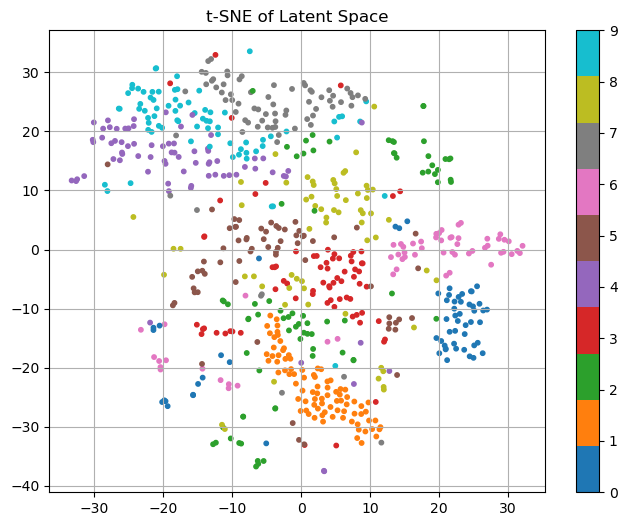

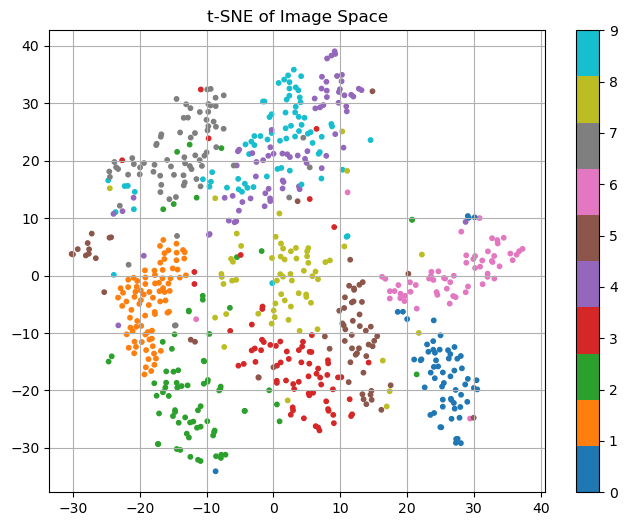


--- Summary ---
Dataset: MNIST
Latent Dimension: 128
Autoencoder Final MSE Loss: 0.006715
Autoencoder Final MAE Loss: 0.025755
Classifier Train Accuracy: 99.69%
Classifier Validation Accuracy: 98.12%
Classifier Test Accuracy: 97.88%


In [42]:
# Cell 13: Evaluate Classifier and Visualize t-SNE
# Evaluate on test set
import matplotlib.pyplot as plt


print("\n--- Evaluating Classifier ---")
test_accuracy = evaluate_classifier(encoder, classifier, test_loader, device)

# Plot t-SNE visualization using the provided plot_tsne function from utils.py
print("\n--- Computing t-SNE Visualization ---")
# Replace the plot_tsne call with:
print("\n--- Computing t-SNE Visualization ---")
custom_plot_tsne(encoder, test_loader, device)  # Use custom function instead of plot_tsne

# Print summary
print("\n--- Summary ---")
print(f"Dataset: {('MNIST' if use_mnist else 'CIFAR10')}")
print(f"Latent Dimension: {LATENT_DIM}")
print(f"Autoencoder Final MSE Loss: {mse_losses[-1]:.6f}")
print(f"Autoencoder Final MAE Loss: {mae_losses[-1]:.6f}")
print(f"Classifier Train Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Classifier Validation Accuracy: {val_accuracies[-1]:.2f}%")
print(f"Classifier Test Accuracy: {test_accuracy:.2f}%")